# Orbitrap Data Analysis Code
#### Developer: ssz; Last modified: July 8, 2020

### Load the analysis code

In [1]:
run DataAnalyzer.py

### Process a folder of data

In [6]:
#Set up the inputs

#Folder with FT Statistic-ified files. All the files need to be processed using the same metrics.
#inputSampleFolder = "/Users/sarahzeichner/Documents/Caltech/Research/Direct Injection/DirectInjectionData/July152020/Sample"
inputStandardFolder = "/Users/sarahzeichner/Documents/Caltech/Research/Direct Injection/DirectInjectionData/July2020/July152020/Standard"
#Isotope list, in the order it was processed by FT Stat.
isotopeList = ['UnSub','15N','13C']
#Whether or not you are accounting for a GC or column elution
gc_elution_on = True
#Time frames for the GC elution
stdpeakTimeFrames = peakTimeFrames = [(6.65,6.78), (7.85, 8.12), (9.95,10.15), (10.21, 10.40), (12.32,12.47)]
#samplepeakTimeFrames = [(6.65,6.78), (7.85, 8.12), (9.95,10.15), (12.32,12.47)]
#Ratios to omit in data processing
omitRatios = ['15N/13C', '13C/15N']
#Any specific properties you want to cull on
cullOn = None
#Multiple of SD you want to cull beyond for the cullOn property
cull_amount = 2
#Whether you want to cull zero scans
cullZeroScans = False
#Whether you want to calculate weighted averages based on NL height (specifically designed for GC elution but widely applicable!)
weightByNLHeight = True
#Whether you want to output each file as you process it, and where you want it to go:
fileOutputPath = None

#Let's do it! This populates both output for each file and also statistics for all the files.
#SampleOutput,SampleStatsOutput=DataAnalyzer.calc_Folder_Output(inputSampleFolder, cullOn=cullOn, cullZeroScansOn=cullZeroScans, gcElutionOn=gc_elution_on, weightByNLHeight=weightByNLHeight, gcElutionTimes = peakTimeFrames,  cullAmount=cull_amount, isotopeList = isotopeList, NL_over_TIC=0.10, omitRatios = omitRatios, fileCsvOutputPath=fileOutputPath)
StdOutput,StdStatsOutput=calc_Folder_Output(inputStandardFolder, cullOn=cullOn, cullZeroScansOn=cullZeroScans, gcElutionOn=gc_elution_on, weightByNLHeight=weightByNLHeight, gcElutionTimes = peakTimeFrames,  cullAmount=cull_amount, isotopeList = isotopeList, NL_over_TIC=0.10, omitRatios = omitRatios, fileCsvOutputPath=fileOutputPath)

/Users/sarahzeichner/Documents/Caltech/Research/Direct Injection/DirectInjectionData/July2020/July152020/Standard/1_StdMix1_5.xlsx
Ratios omitted:13C/15N
Ratios omitted:15N/13C
Ratios omitted:15N/13C
Ratios omitted:15N/13C


KeyError: 'TICVar'

Print output for all files, fragments, and isotope ratios

In [3]:
Output

,FileNumber,Fragment,IsotopeRatio,Average,StdDev,StdError,RelStdError
3,/Users/sarahzeichner/Documents/Caltech/Researc...,138,13C/UnSub,0.042040,0.004239,0.000313,0.007453
13,/Users/sarahzeichner/Documents/Caltech/Researc...,138,13C/UnSub,0.042225,0.002505,0.000185,0.004385
23,/Users/sarahzeichner/Documents/Caltech/Researc...,138,13C/UnSub,0.042254,0.002342,0.000173,0.004097
2,/Users/sarahzeichner/Documents/Caltech/Researc...,138,15N/UnSub,0.003093,0.001029,0.000076,0.024598
12,/Users/sarahzeichner/Documents/Caltech/Researc...,138,15N/UnSub,0.003232,0.000602,0.000044,0.013764
22,/Users/sarahzeichner/Documents/Caltech/Researc...,138,15N/UnSub,0.003299,0.000534,0.000039,0.011957
1,/Users/sarahzeichner/Documents/Caltech/Researc...,140,13C/UnSub,0.003327,0.000403,0.000059,0.017862
11,/Users/sarahzeichner/Documents/Caltech/Researc...,140,13C/UnSub,0.003374,0.000309,0.000046,0.013502
21,/Users/sarahzeichner/Documents/Caltech/Researc...,140,13C/UnSub,0.003188,0.000264,0.000039,0.012229
0,/Users/sarahzeichner/Documents/Caltech/Researc...,140,15N/UnSub,0.041940,0.001935,0.000285,0.006804


Print statistical summary

In [4]:
StatsOutput

Fragment           138                 140                 153            \
IsotopeRatio 13C/UnSub 15N/UnSub 13C/UnSub 15N/UnSub 13C/UnSub 15N/UnSub   
Avg R Val     0.042173  0.003208  0.003296  0.042241  0.030446  0.001450   
N             3.000000  3.000000  3.000000  3.000000  3.000000  3.000000   
StdDev        0.000116  0.000105  0.000097  0.000290  0.015839  0.001520   
StdError      0.000067  0.000061  0.000056  0.000168  0.009145  0.000878   
RelStdError   0.001594  0.018892  0.016994  0.003970  0.300354  0.605451   

Fragment           156                 166            
IsotopeRatio 13C/UnSub 15N/UnSub 13C/UnSub 15N/UnSub  
Avg R Val     0.037156  0.001532  0.061937  0.001405  
N             3.000000  3.000000  3.000000  3.000000  
StdDev        0.005063  0.001605  0.002117  0.001622  
StdError      0.002923  0.000927  0.001222  0.000937  
RelStdError   0.078670  0.604928  0.019735  0.666553

### Analyze one specific raw file

Define the input file and the list of isotopes you extracted in order, as they were extracted from FTStatistic. 

By default, the code will compute ratio for every combination; here 13C/15N, 13C/UnSub, and 15N/UnSub. If you don't care about some of those (i.e. 13C/15N), you should add that ration and its inverse to omitRatios. In this case, you could write omitRatios = ['13C/15N','15N/13C']. 

(Note: the following code is basically un-modified from T.C. code from March 2020).

In [43]:
#Specific file name to look at
inputStandardFile = '/Users/sarahzeichner/Documents/Caltech/Research/Direct Injection/DirectInjectionData/July2020/July152020/Standard/1_StdMix1_3.xlsx'
#inputStandardFile = '/Users/sarahzeichner/Documents/Caltech/Research/Direct Injection/DirectInjectionData/July2020/July172020/Standard/1_100D_dot_StdMix1_2.xlsx'
outputPath = ''
isotopeList = ['UnSub','15N','13C']
gc_elution_on = True
peakTimeFrames = [(6.65,6.78), (7.85, 8.12), (9.95,10.15), (10.21, 10.40), (12.32,12.47)]
omitRatios = ['15N/13C', '13C/15N']

Import the data into a workable form (i.e., The FTStat import has each peak (single line of FTStat input code, i.e. a 13C or 15N peak) as a separate dataframe. This code combines these so that each fragment (where a fragment is a set of peaks, i.e. the 109 fragment as a 13C, 15N, and Unsubstituted peak) has a single dataframe. It then culls scans that fall outside of some threshold, i.e. here with TIC * IT more than three standard deviations from the mean. Note the isotopeList input is the same as defined in input 2; the same isotopeList is used in multiple functions and should be carried through the entire script, so it is easiest to change it once at the start.)

In [44]:
peaks = import_Peaks_From_FTStatFile(inputStandardFile)
pandas = convert_To_Pandas_DataFrame(peaks)
Merged =combine_Substituted_Peaks(peakDF=pandas, cullOn = None, cullZeroScansOn = False, gc_elution_on = gc_elution_on, gc_elution_times = peakTimeFrames, cullAmount = 2, isotopeList = isotopeList, NL_over_TIC = 0.10, csv_output_path=None)

Analyze data quality related to the AGC system, determining how TIC, IT, and TIC * IT vary with retention time and with each other. 

(Note: not sure how this applies to separate parts of the GC, especially once it is culled for each fragment). 

It also prints the standard deviation of each. 
good <0.05-0.07
ok < 0.10
bad >0.10

**Notes:**
**You can change the df=Merged[x] line in order to look at the data quality of each fragment**

You may want to change to scatter plots; in the ax.plot line, change ax.plot to ax.scatter. 

TIC Mean and STD
1.65e+10
0.79
IT Mean and STD
6.20e-02
0.11
TIC*IT Mean and STD
9.94e+05
0.78


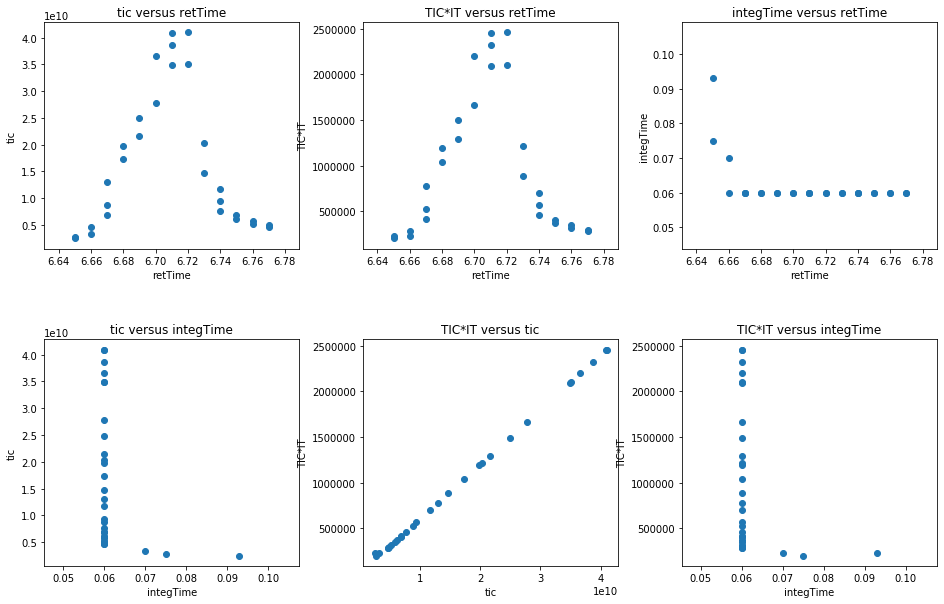

In [45]:
#Intiialize figure
fig = plt.figure(figsize=(16, 10))

#Initializes an outer grid. Sets of subplots for each peak will be placed into this outer grid. 
numberOfPeaks = 5
outer_grid = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.25)

#What do you want to look at?
df = Merged[0] #change the index to look at the fragment of interest

#The base case gives the tic plots for the whole measurement, then the loop plots each fragment
for i in range(numberOfPeaks):
    if i == 0:
        inner_grid = gridspec.GridSpecFromSubplotSpec(2, 3,
            subplot_spec=outer_grid[i], wspace=0.25, hspace=0.40)

        plotlist = [('retTime','tic'),('retTime','TIC*IT'),('retTime','integTime'),('integTime','tic'),('tic','TIC*IT'),('integTime','TIC*IT')]

        for item in plotlist:
            ax = plt.Subplot(fig, inner_grid[plotlist.index(item)])
            ax.scatter(df[item[0]].tolist(),df[item[1]].tolist())
            ax.set_xlabel(item[0])
            ax.set_ylabel(item[1])
            ax.set_title(item[1] + ' versus ' + item[0])
            fig.add_subplot(ax)

    else:
        pass
print('TIC Mean and STD')
print('{:.2e}'.format(df['tic'].mean()))
print(round(df['tic'].std()/df['tic'].mean(),2))
print('IT Mean and STD')
print('{:.2e}'.format(df['integTime'].mean()))
print(round(df['integTime'].std()/df['integTime'].mean(),2))
print('TIC*IT Mean and STD')
print('{:.2e}'.format(df['TIC*IT'].mean()))
print(round(df['TIC*IT'].std()/df['TIC*IT'].mean(),2))


Analyze R values as a function of retention time and the AGC variables (TIC, IT, etc.).

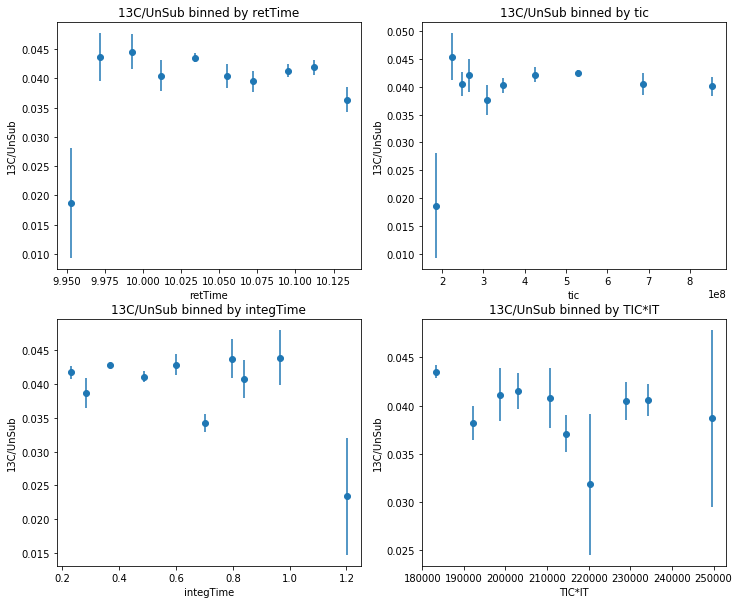

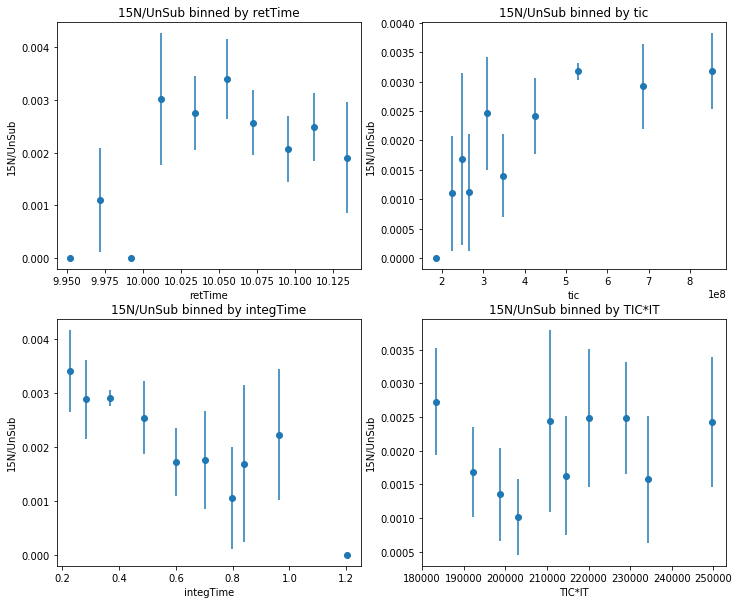

In [33]:
df = Merged[2]
numBins = 10    
xvars = ['retTime','tic','integTime','TIC*IT']
count = df.shape[0]/10

#N.B: I use the name specialIsotopeList to avoid overwriting the isotopeList variable the rest of the code uses. 
#One could avoid this by making this a separate function, but I mess with this code often enough (and it takes
#a while to import large excel sheets for many fragment measurements) so I leave it by itself here. This may be 
#a little confusing, and should be resolved whenever we figure out the best way to reduce variation based on 
#TIC*IT to a single number saying "good" or "bad", which is the ultimate goal. 

specialIsotopeList = ['13C','15N']
for isotope in specialIsotopeList:
    
    fig = plt.figure(figsize=(12,10))
    
    for variable in xvars:

        avgXList = []
        avgYList = []
        errorList = []

        for div in range(0,numBins):

            if isotope + '/UnSub' in df:
                targetVariable = isotope + '/UnSub'
            else:
                targetVariable = 'UnSub/' + isotope

            sortDf = df.sort_values(by=[variable])
            division = [int(div * count//1),int((div+1)*count//1)]
            restrictDf = sortDf.iloc[list(range(division[0],division[1]))]
            Ymean = np.mean(restrictDf[targetVariable])
            YStd = np.std(restrictDf[targetVariable])
            YStError = YStd / np.power(len(restrictDf),0.5)
            Xmean = np.mean(restrictDf[variable])

            avgXList.append(Xmean)
            avgYList.append(Ymean)
            errorList.append(YStError)

        plt.subplot(2,2,xvars.index(variable)+1)
        plt.errorbar(avgXList, avgYList, errorList, fmt='o')
        plt.xlabel(variable)
        plt.ylabel(targetVariable)
        plt.title(targetVariable + ' binned by ' + variable)

    plt.show()

Calculate and plot output for a single raw file. 
You may need to mess with the numCols, widthMultiple, and heightMultiple variables (increasing the latter two makes the figure wider or taller) to make the figure appear nice for different numbers of plots. 

Ratios omitted:15N/13C
Ratios omitted:15N/13C
Ratios omitted:15N/13C
Ratios omitted:15N/13C


/Users/sarahzeichner/Documents/Caltech/Research/Orbitrap Data Processing Script/AnyRatioAnalysis_SZ.py:333: RuntimeWarning: invalid value encountered in double_scalars
  rtnDict[massStr][header]['RelStError'] = rtnDict[massStr][header]['StError'] / rtnDict[massStr][header]['Ratio']
/Users/sarahzeichner/Documents/Caltech/Research/Orbitrap Data Processing Script/AnyRatioAnalysis_SZ.py:334: RuntimeWarning: divide by zero encountered in double_scalars
  rtnDict[massStr][header]['ShotNoiseLimit by Quadrature'] = (1/dfList[fragmentIndex]['counts' + isotopeList[i]].sum() +1/dfList[fragmentIndex]['counts' + isotopeList[j]].sum())**(1/2)


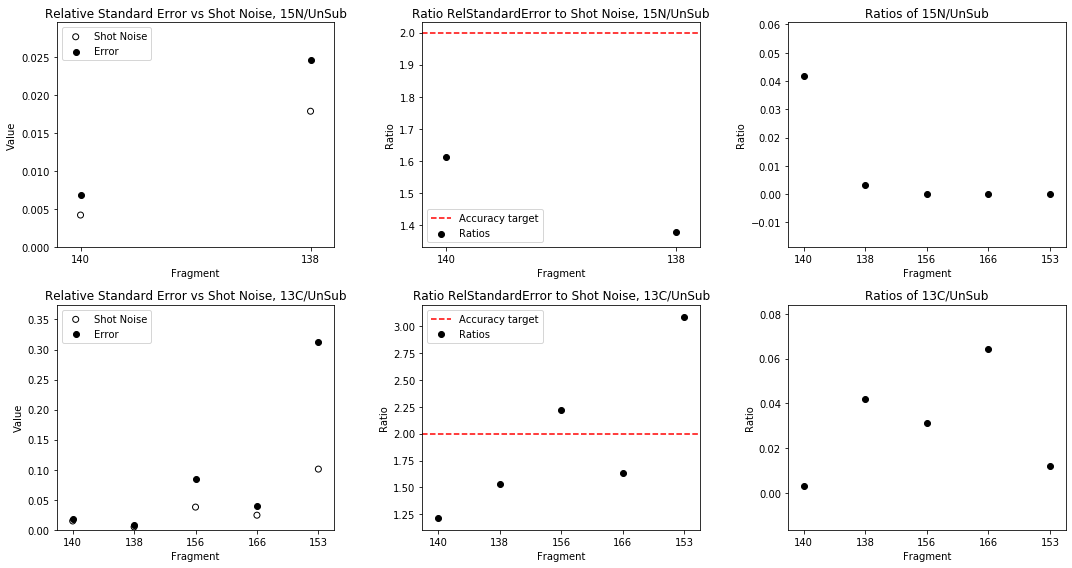

In [7]:
output = _calcRawFileOutput(Merged, gc_elution_on, isotopeList, omitRatios)
_plotOutput(output,isotopeList = isotopeList,omitRatios = omitRatios,numCols = 3, widthMultiple = 5, heightMultiple = 4)